# Library Preparation

In [ ]:
pip install sentence_transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from torch.optim import Adam
from skopt import gp_minimize
from scipy.signal import argrelextrema
from scipy.sparse import csr_matrix
from sklearn.model_selection import KFold
from scipy.stats import hmean
from itertools import product
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Mounted at /content/drive


# Data Processing

## Queries

In [ ]:
def read_queries_in_batches(filepath, batch_size=2000):
    with open(filepath, 'r') as file:
        batch = []
        for i, line in enumerate(file, start=1):
            line = line.strip()
            if line:
                batch.append((i, line))
            if len(batch) == batch_size:
                yield batch
                batch = []
        if batch:
            yield batch

def cosine_similarity(vec1, vec2):
    vec1 = np.squeeze(vec1)
    vec2 = np.squeeze(vec2)
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def get_ave_cos_similarity(flu_related_embedding, queries_embedding):
    ave_cos_sim = []
    for query_id, q_embedding in queries_embedding:
        all_cos_sim = [cosine_similarity(q_embedding, f) for f in flu_related_embedding]
        average = sum(all_cos_sim) / len(all_cos_sim)
        ave_cos_sim.append([query_id, average])
    return ave_cos_sim

In [ ]:
file_path = '/content/drive/My Drive/project/queries.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    queries = file.readlines()

queries = [query.strip() for query in queries]

queries[0]

'flu medicine'

In [ ]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

flu_related = ['flu', 'fever', 'flu medicine', 'gp', 'hospital', 'flu symptoms', 'influenza vaccine']
flu_embedding = [embedding_model.encode([f]) for f in flu_related]

queries_filepath = '/content/drive/My Drive/project/queries.txt'
batch_size = 2000
all_ave_cos_sim = []
i = 0

for batch in read_queries_in_batches(queries_filepath, batch_size):
    if not batch:
        print("Batch processing finished")
        break
    i += 1
    q_embedding = [(query_id, embedding_model.encode([query])) for query_id, query in batch]
    batch_ave_cos_sim = get_ave_cos_similarity(flu_embedding, q_embedding)
    all_ave_cos_sim.extend(batch_ave_cos_sim)
    print(f"{i} done")

sorted_ave_cos_sim = sorted(all_ave_cos_sim, key=lambda x: x[1], reverse=True)
top_5000_cos_sim = sorted_ave_cos_sim[:2000]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done


In [ ]:
q_embedding[0]

(22001,
 array([[-2.32527368e-02,  5.60223721e-02, -2.80132312e-02,
          2.93513983e-02,  2.91449055e-02,  3.10505200e-02,
          2.41540708e-02, -1.88764855e-02,  2.61375457e-02,
          2.76996810e-02,  5.74110169e-03, -4.80585881e-02,
          4.12410684e-02, -1.94575004e-02, -5.08954301e-02,
         -4.25796732e-02, -8.25488046e-02, -8.67275670e-02,
          3.29128541e-02,  5.91632910e-02, -1.32778183e-01,
          6.18273430e-02, -5.17085195e-02,  5.79996333e-02,
         -6.41425252e-02,  1.19896688e-01,  2.14456469e-02,
         -3.22412252e-02, -5.85323572e-02, -5.22160046e-02,
          4.48138341e-02, -1.04112923e-02, -9.28609669e-02,
         -3.83936875e-02,  4.33592759e-02,  3.36073227e-02,
         -6.15906902e-02,  2.99874153e-02, -2.23702062e-02,
          1.24051310e-02, -4.22146432e-02,  5.62633909e-02,
         -7.98205137e-02, -2.19531562e-02,  5.19354455e-02,
          5.29919825e-02,  5.86497178e-03,  6.05800701e-03,
          7.95515105e-02,  1.566

In [ ]:
sorted_ave_cos_sim[0]

[4272, 0.6210884324141911]

In [ ]:
query_id = [int(item[0]) -1 for item in top_5000_cos_sim]

In [ ]:
query_id[0]

4271

In [ ]:
selected_queries = [queries[number] for number in query_id if number < len(query_id)]

# 打印结果
print(selected_queries)

['flu infection', 'virus flu', 'fever flu', 'flu medicine', 'flu a', 'anti flu', 'flu virus', 'nhs flu', 'flu nhs', 'flu clinic', 'severe flu', 'winter flu', 'flu medication', 'flu like virus', 'flu shots', 'flu like', 'flu outbreak', 'flu treatment', 'flu epidemic', 'treat the flu', 'flu viruses', 'child flu', 'flu cure', 'influenza treatment', 'flu cough', 'cold and flu', 'flu cases', 'flu vaccine', 'medicine for flu', 'treat flu', 'the flu vaccine', 'mild flu', 'flu jab', 'cure flu', 'i have flu', 'flu wikipedia', 'what is flu', 'flu vaccination', 'cold and flu medicine', 'flu jabs', 'the flu jab', 'flu treatments', 'flu funny', 'influenza vaccine', 'treatment for flu', 'flu injections', 'cdc flu', 'flu vaccine nhs', 'get rid of flu', 'flu quiz', 'medication for flu', 'flu strains', 'flu symptom', 'flu test', 'flu jab nhs', 'flu recovery', 'influenza vaccination', 'flu vaccinations', 'fever medicine', 'flu vaccines', 'nasal flu', 'flu strain', 'nhs direct flu', 'colds and flu', 'flu

## Query Freq

In [ ]:
file_path = '/content/drive/My Drive/project/Q_freq_sparse.csv'
dates_file_path = '/content/drive/My Drive/project/dates.txt'

def weighted_harmonic_mean(window):
    weights = np.array([1/(i+1) for i in range(len(window))])
    weighted_sum = np.sum(window * weights)
    normalization_factor = np.sum(weights)
    return weighted_sum / normalization_factor

In [ ]:
chunk_size = 10000
filtered_chunks = []
top_5000_query_ids = {item[0] for item in top_5000_cos_sim}

for chunk in pd.read_csv(file_path, header=None, names=['date', 'query', 'freq'], chunksize=chunk_size):
    chunk_filtered = chunk[chunk['query'].isin(top_5000_query_ids)]
    filtered_chunks.append(chunk_filtered)

Q_freq_filtered = pd.concat(filtered_chunks)

In [ ]:
Q_freq_filtered

,date,query,freq
0,6453.0,20865.0,99999.882482
9,1289.0,6865.0,9999.415315
11,2767.0,6865.0,9999.291550
16,6460.0,20865.0,99986.537685
21,2100.0,6865.0,9998.595771
...,...,...,...
53471802,6669.0,20893.0,10.096025
53471829,6673.0,21330.0,10.056201
53471846,6699.0,21330.0,10.017762
53471847,6699.0,20893.0,10.017017


In [ ]:
import pandas as pd

max_query = Q_freq_filtered['query'].max()
min_query = Q_freq_filtered['query'].min()

print(f"最大值: {max_query}")
print(f"最小值: {min_query}")


最大值: 22548.0
最小值: 1.0


In [ ]:
dates_df = pd.read_csv(dates_file_path, header=None, names=['date'])
dates_df['date'] = pd.to_datetime(dates_df['date'], format='%Y%m%d')
date_mapping = {i+1: date for i, date in enumerate(pd.to_datetime(dates_df['date']))}

def map_date(numeric_date):
    return date_mapping.get(numeric_date, pd.NaT)

Q_freq_filtered['date'] = Q_freq_filtered['date'].apply(map_date)

In [ ]:
start_date = pd.to_datetime('2004-09-01')
end_date = pd.to_datetime('2019-08-31')
full_date_range = pd.date_range(start=start_date, end=end_date)

Q_freq_filtered = Q_freq_filtered[(Q_freq_filtered['date'] >= start_date) & (Q_freq_filtered['date'] <= end_date)]

smoothed_freq_list = []
query_counter = 0

for query_id, group in Q_freq_filtered.groupby('query'):
    group = group.set_index('date').reindex(full_date_range, fill_value=0).reset_index().rename(columns={'index': 'date'})
    group['query'] = query_id
    group['smoothed_freq'] = group['freq'].rolling(window=14, min_periods=1).apply(weighted_harmonic_mean, raw=True)
    smoothed_freq_list.append(group)
    query_counter += 1
    if query_counter % 250 == 0:
        print(f'{query_counter} queries have done.')

Q_freq_filtered_smoothed = pd.concat(smoothed_freq_list).sort_values(by=['query', 'date'])

print(Q_freq_filtered_smoothed.head(20))

250 queries have done.
500 queries have done.
750 queries have done.
1000 queries have done.
         date  query        freq  smoothed_freq
0  2004-09-01    1.0    0.000000       0.000000
1  2004-09-02    1.0    0.000000       0.000000
2  2004-09-03    1.0    0.000000       0.000000
3  2004-09-04    1.0    0.000000       0.000000
4  2004-09-05    1.0    0.000000       0.000000
5  2004-09-06    1.0    0.000000       0.000000
6  2004-09-07    1.0    0.000000       0.000000
7  2004-09-08    1.0    0.000000       0.000000
8  2004-09-09    1.0    0.000000       0.000000
9  2004-09-10    1.0    0.000000       0.000000
10 2004-09-11    1.0    0.000000       0.000000
11 2004-09-12    1.0    0.000000       0.000000
12 2004-09-13    1.0    0.000000       0.000000
13 2004-09-14    1.0    0.000000       0.000000
14 2004-09-15    1.0    0.000000       0.000000
15 2004-09-16    1.0    0.000000       0.000000
16 2004-09-17    1.0    0.000000       0.000000
17 2004-09-18    1.0    0.000000       0.00

In [ ]:
pivot_df = Q_freq_filtered_smoothed.pivot(index='date', columns='query', values='smoothed_freq').fillna(0)

pivot_df.reset_index(inplace=True)

input_vectors_with_date = pivot_df

print("输入向量形状：", input_vectors_with_date.shape)
print(input_vectors_with_date.head())

输入向量形状： (5478, 1020)
query       date  1.0  2.0  5.0  10.0  11.0  12.0  13.0        14.0  \
0     2004-09-01  0.0  0.0  0.0   0.0   0.0   0.0   0.0  238.928789   
1     2004-09-02  0.0  0.0  0.0   0.0   0.0   0.0   0.0  159.285859   
2     2004-09-03  0.0  0.0  0.0   0.0   0.0   0.0   0.0  130.324794   
3     2004-09-04  0.0  0.0  0.0   0.0   0.0   0.0   0.0  114.685819   
4     2004-09-05  0.0  0.0  0.0   0.0   0.0   0.0   0.0  104.640346   

query        15.0  ...  22471.0    22472.0     22473.0     22474.0  \
0      238.985675  ...      0.0    0.00000    0.000000    0.000000   
1      159.323784  ...      0.0    0.00000    0.000000    0.000000   
2      130.355823  ...      0.0    0.00000    0.000000  157.998531   
3      114.713124  ...      0.0    0.00000    0.000000  139.038707   
4      104.665259  ...      0.0  147.35311  264.321363  126.860134   

query     22475.0  22476.0     22540.0  22543.0  22547.0     22548.0  
0      925.625066      0.0    0.000000      0.0      0.0    

In [ ]:
output_filepath = '/content/drive/My Drive/project/input_vectors_with_date.csv'
input_vectors_with_date.to_csv(output_filepath, index=False)

文件已保存到 /content/drive/My Drive/project/input_vectors_with_date.csv


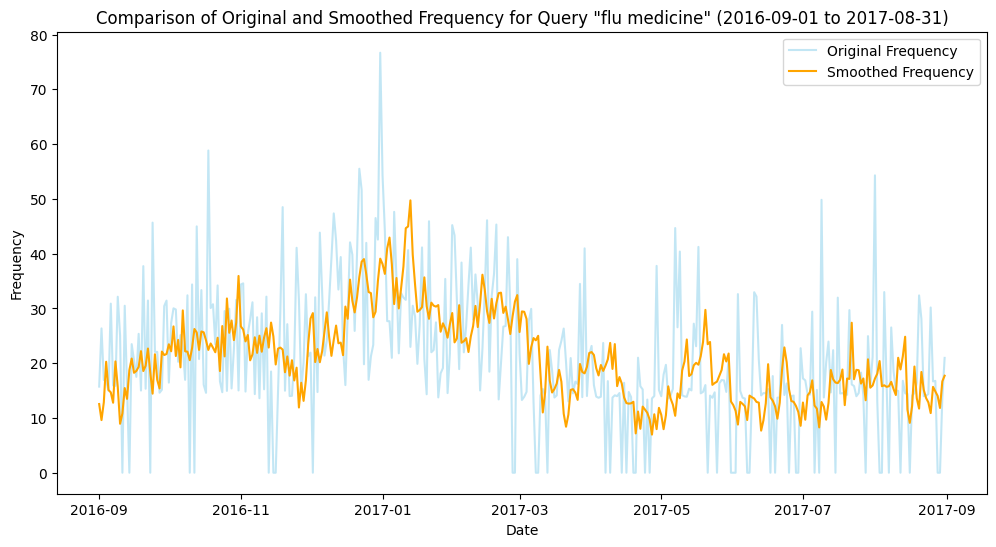

In [ ]:
start_date = pd.to_datetime('2016-09-01')
end_date = pd.to_datetime('2017-08-31')

query_1_data = Q_freq_filtered_smoothed[Q_freq_filtered_smoothed['query'] == 1]

query_1_data_filtered = query_1_data[(query_1_data['date'] >= start_date) & (query_1_data['date'] <= end_date)]

plt.figure(figsize=(12, 6))
plt.plot(query_1_data_filtered['date'], query_1_data_filtered['freq'], label='Original Frequency', color='skyblue', alpha=0.5)
plt.plot(query_1_data_filtered['date'], query_1_data_filtered['smoothed_freq'], label='Smoothed Frequency', color='orange')
plt.title('Comparison of Original and Smoothed Frequency for Query "flu medicine" (2016-09-01 to 2017-08-31)')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("flu_medicine_Q_freq.pdf")
plt.show()


## ILI Rate

In [ ]:
ILI = pd.read_csv('/content/drive/My Drive/project/ILI_rates_RCGP.csv')
print(ILI.head())

    WeekStart    WeekEnd  ILIRate
0  12/29/2003   1/4/2004  13.3687
1    1/5/2004  1/11/2004  15.4597
2   1/12/2004  1/18/2004   9.3099
3   1/19/2004  1/25/2004   7.1897
4   1/26/2004   2/1/2004   5.7876


In [ ]:
ILI['WeekStart'] = pd.to_datetime(ILI['WeekStart'])
ILI['WeekEnd'] = pd.to_datetime(ILI['WeekEnd'])

ILI['MidWeek'] = ILI['WeekStart'] + pd.DateOffset(days=3)

x = np.array([(date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s') for date in ILI['MidWeek']])
y = ILI['ILIRate'].values

linear_interp = interp1d(x, y, kind='linear', bounds_error=False, fill_value="extrapolate")

date_range = pd.date_range(start="2008-09-01", end="2019-08-31")
x_new = np.array([(date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s') for date in date_range])

y_new = linear_interp(x_new)

interpolated_ili = pd.DataFrame({
    'Date': date_range,
    'ILIRate': y_new
})

ILI_filtered = ILI[(ILI['MidWeek'] >= "2008-09-01") & (ILI['MidWeek'] <= "2019-08-31")]

plt.figure(figsize=(18, 6))
plt.plot(interpolated_ili['Date'], interpolated_ili['ILIRate'], label='Interpolated ILI Rate', color='blue')
plt.scatter(ILI_filtered['MidWeek'], ILI_filtered['ILIRate'], color='red', label='Weekly ILI Rate', s=10)  # Adjust the size with `s` parameter
plt.legend(fontsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('ILI Rate', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(True)
plt.title('Linear Interpolation of ILI Rates', fontsize=18)
plt.savefig("ILI.pdf")
plt.show()

In [ ]:
interpolated_ili['Date'] = pd.to_datetime(interpolated_ili['Date'])
interpolated_ili

In [ ]:
file_path = '/content/drive/My Drive/project/interpolated_ili.csv'
interpolated_ili.to_csv(file_path, index=False)